In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy
import scipy
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import os
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib

#
#data_file_name='data/sacct_mazama_out_2.out'
data_file_name = 'data/mazama_usage_20200506_tool8.out'
#data_file_name = 'data/sacct_mazama_out_20200506a.out'

In [4]:
load_pickle=True
pkl_name = "{}.pkl".format(os.path.splitext(data_file_name)[0])
#
if load_pickle:
    with open(pkl_name, 'rb') as fin:
        sacct_mazama=pickle.load(fin)
    #
else:
    sacct_mazama = hpc_lib.SACCT_data_handler(data_file_name=data_file_name)
    #
    
    with open(pkl_name, 'wb') as fout:
            #out_pkl = pickle.dump(sacct_demo.jobs_summary, fout)
            out_pkl = pickle.dump(sacct_mazama, fout)

In [5]:
max_submit, max_start = [mpd.num2date(numpy.nanmax(sacct_mazama.jobs_summary[cl])) for cl in ['Start', 'Submit'] ]
print('*** max_submit: {}, max_start: {}'.format(*[mpd.num2date(numpy.nanmax(sacct_mazama.jobs_summary[cl])) for cl in ['Start', 'Submit'] ]))

*** max_submit: 2020-05-06 14:47:13+00:00, max_start: 2020-05-06 14:47:13+00:00


In [6]:
#
cpu_usage = sacct_mazama.active_jobs_cpu()
#
bin_size=7
cpu_weekly = sacct_mazama.active_jobs_cpu(bin_size=bin_size, t_min=None)

** DEBUG:  (1, 1381096) (1, 1381096)
** DEBUG:  (1, 1381096) (1, 1381096)


In [7]:
print('** ', len(cpu_usage['time']))
print('** ** ', sacct_mazama.data[0:5])
print('** ', sacct_mazama.data.dtype)

**  5000
** **  [(0, 'rmorsini', 'users', '100', 'bash', '67', '67', 'ere', 'COMPLETED',  7.,   2,  1, 737407.97196759, 737407.97196759, 737407.97196759, 737407.97201389, 4.62962963e-05, '00:00.011', '00:00.007', '00:00.018', None, '8', '00:00:00', '67')
 (1, None, None, None, 'extern', '67.extern', '67.extern', None, 'COMPLETED', nan,   2,  1, 737407.97196759, 737407.97196759, 737407.97196759, 737407.97201389, 4.62962963e-05, '00:00:00', '00:00.001', '00:00.001', '1', '8', '00:00:00', '67')
 (2, None, None, None, 'bash', '67.0', '67.0', None, 'COMPLETED', nan,   2,  1, 737407.97196759, 737407.97196759, 737407.97196759, 737407.97201389, 4.62962963e-05, '00:00.011', '00:00.005', '00:00.016', '1', '8', '00:00:00', '67')
 (3, 'rmorsini', 'users', '100', 'UOF_TES', '68', '68', 'suprib', 'FAILED',  7., 200, 10, 737407.9724537 , 737407.9724537 , 737407.9724537 , 737407.97246528, 1.15740741e-05, '00:00.007', '00:00.006', '00:00.013', None, '200', '00:00:00', '68')
 (4, None, None, None, 'batc

[Text(737400.0, 0, '2019-12-7'),
 Text(737420.0, 0, '2019-12-27'),
 Text(737440.0, 0, '2020-1-16'),
 Text(737460.0, 0, '2020-2-5'),
 Text(737480.0, 0, '2020-2-25'),
 Text(737500.0, 0, '2020-3-16'),
 Text(737520.0, 0, '2020-4-5'),
 Text(737540.0, 0, '2020-4-25'),
 Text(737560.0, 0, '2020-5-15'),
 Text(737580.0, 0, '2020-6-4')]

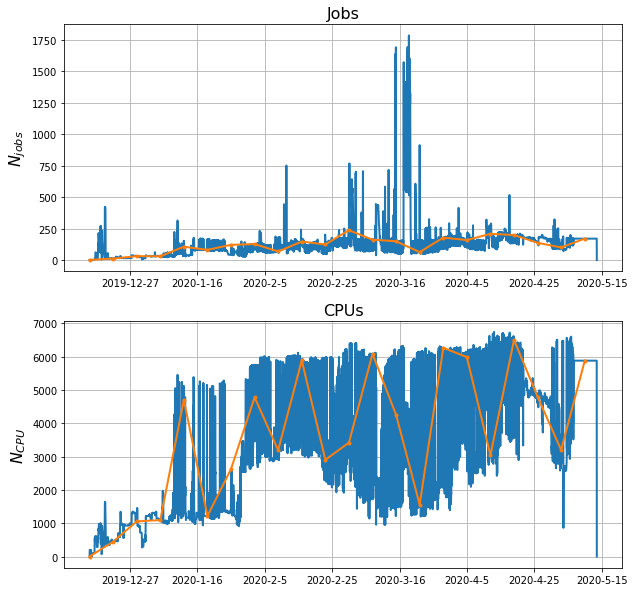

In [8]:
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_usage['time'], cpu_usage['N_jobs'], ls='-', lw=2., marker='')
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='.')
#
ax2.plot(cpu_usage['time'], cpu_usage['N_cpu'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='.')
#

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax2.set_xticklabels(lbls)



In [9]:
def time_bin_aggregates(XY, bin_mod=24, qs=[.25, .5, .74]):
    XY=numpy.array(XY)
    if XY.shape[0]==2:
        X = XY[0,:]
        Y = XY[1:]
    else:
        X = XY[:,0]
        Y = XY[:,1]
    #
    #X_mod = ((X*bin_mod)%bin_mod).astype(int)
    X_mod = ((X%1.)*bin_mod).astype(int)
    #
    stats_output=[]
    for x in numpy.unique(X_mod):
        ix = X_mod==x
        this_Y = Y[ix]
        stats_output += [numpy.append([x, numpy.mean(this_Y), numpy.std(this_Y)],
                                      numpy.quantile(this_Y, qs))]
    #
    return numpy.core.records.fromarrays(numpy.array(stats_output).T, dtype=[('x', '>f8'), ('mean', '>f8'),
                                                        ('stdev', '>f8')] + 
                                         [('q_{}'.format(q), '>f8') for q in qs])
#

    

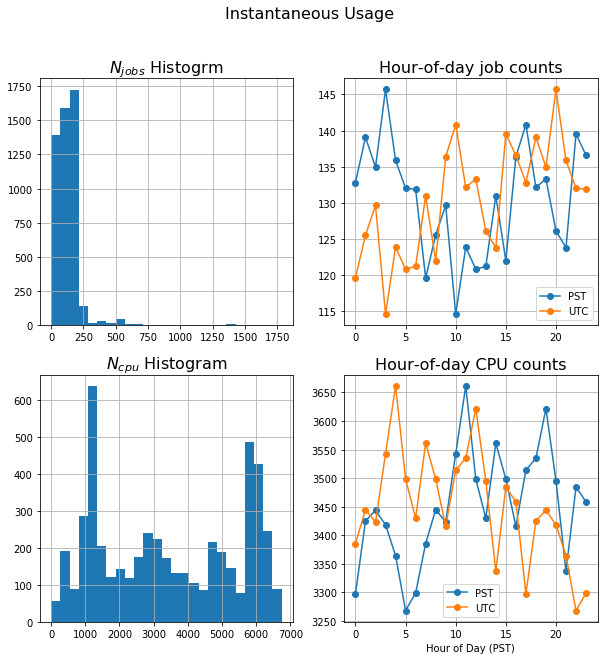

In [12]:
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('221')
ax2 = fg.add_subplot('222')
ax3 = fg.add_subplot('223')
ax4 = fg.add_subplot('224')
axs = [ax1, ax2, ax3, ax4]
[ax.grid() for ax in axs]
#
cpu_hourly = time_bin_aggregates(XY=numpy.array([cpu_usage['time'], cpu_usage['N_cpu']]).T)
jobs_hourly = time_bin_aggregates(XY=numpy.array([cpu_usage['time'], cpu_usage['N_jobs']]).T)

ix_pst = numpy.argsort( (jobs_hourly['x']-7)%24)
#
hh1 = ax1.hist(sorted(cpu_usage['N_jobs'])[0:int(1.0*len(cpu_usage))], bins=25, cumulative=False)
ax2.plot(jobs_hourly['x'], jobs_hourly['mean'], ls='-', marker='o', label='PST')
ax2.plot((jobs_hourly['x']), jobs_hourly['mean'][ix_pst], ls='-', marker='o', label='UTC')

hh3 = ax3.hist(cpu_usage['N_cpu'], bins=25)
ax4.plot(cpu_hourly['x'], cpu_hourly['mean'], ls='-', marker='o', label='PST')
ax4.plot( (cpu_hourly['x']), cpu_hourly['mean'][ix_pst], ls='-', marker='o', label='UTC')
#
#ax1.set_ylim(-5., 200)
ax1.set_title('$N_{jobs}$ Histogrm', size=16)
ax2.set_title('Hour-of-day job counts', size=16)
ax3.set_title('$N_{cpu}$ Histogram', size=16)
ax4.set_title('Hour-of-day CPU counts', size=16)
#
ax4.set_xlabel('Hour of Day (PST)')
plt.suptitle('Instantaneous Usage', size=16)

ax2.legend(loc=0)
ax4.legend(loc=0)

In [13]:
weekly_hours = sacct_mazama.get_cpu_hours(bin_size=7, n_points=5000)

daily_hours = sacct_mazama.get_cpu_hours(bin_size=1, n_points=5000)

** DEBUG:  (1381096,) (1381096,)
*** debug: starting IX_k
*** DEBUG: IX_K::  [array([1014433]), array([1014433, 1025545, 1036655, 1047767, 1058877, 1069988, 1081099]), array([1014433, 1025545, 1036655, 1047767, 1058877, 1069988, 1081099,
       1092210, 1103321, 1114432, 1125544]), array([1014433, 1025545, 1036655, 1047767, 1058877, 1069988, 1081099,
       1092210, 1103321, 1114432, 1125544, 1136654, 1147766, 1158877,
       1169988]), array([1014433, 1025545, 1036655, 1047767, 1058877, 1069988, 1081099,
       1092210, 1103321, 1114432, 1125544, 1136654, 1147766, 1158877,
       1169988, 1181099, 1192210, 1203321, 1214434, 1225549, 1236666])]
*** DEBUG: IX_k[0]:  [1014433] <class 'numpy.ndarray'>
***  (5000,)
** DEBUG:  (1381096,) (1381096,)
*** debug: starting IX_k
*** DEBUG: IX_K::  [array([1014433]), array([1014433, 1025545, 1036655, 1047767, 1058877, 1069988, 1081099]), array([1014433, 1025545, 1036655, 1047767, 1058877, 1069988, 1081099,
       1092210, 1103321, 1114432, 1125544

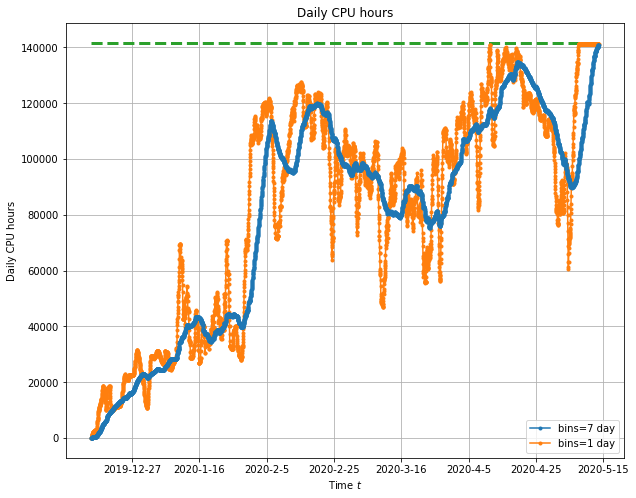

In [29]:
fg = plt.figure(figsize=(10,8))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(weekly_hours['time'], weekly_hours['cpu_hours']/7., ls='-', marker='.', label='bins=7 day', zorder=11)
ax1.plot(daily_hours['time'], daily_hours['cpu_hours'], ls='-', marker='.', label='bins=1 day', zorder=5)


#
fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax1.set_xticklabels(lbls)
ax1.set_xlabel('Time $t$')
ax1.set_ylabel('Daily CPU hours')
ax1.set_title('Daily CPU hours')
#
ax1.legend(loc=0)

ax1.plot(daily_hours['time'][0::len(daily_hours)-1], numpy.ones(2)*123*48*24, ls='--', marker='', lw=3.)

In [26]:
# how many active nodes do we have? looks like tasks/cpus show up as 1/thread, so 48 per node, so...
n_max = numpy.max(daily_hours['cpu_hours'])
#
n_nodes = n_max/(24.*48.)
#
print('*** n_max={}, n_nodes={}'.format(n_max, n_nodes))
#140000/(24*48)

*** n_max=141168.0, n_nodes=122.54166666666667


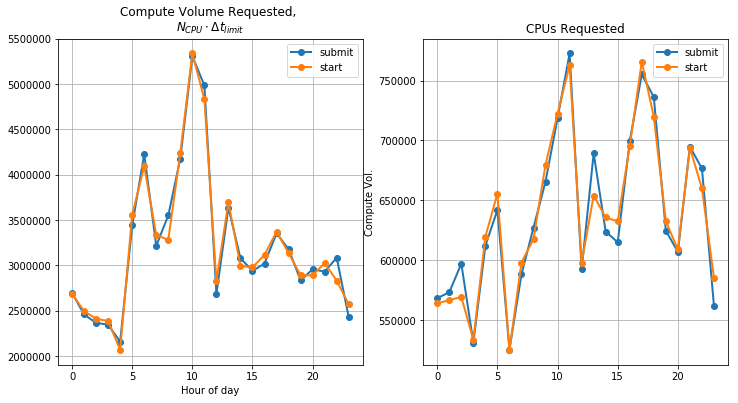

In [32]:
# time of day(-like) compute volume requests.

qs = [.5, .75, .95]
#
comp_vol_submit = sacct_mazama.get_submit_compute_vol_timeofday(qs=qs)
comp_vol_start = sacct_mazama.get_submit_compute_vol_timeofday(time_col='Start', qs=qs)
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot('121')
ax2 = fg.add_subplot('122')
ax1.grid()
ax2.grid()
#

# N = numpy.sum(comp_vol_submit['cpu-time'])
N = 1.
ax1.plot(comp_vol_submit['time'], comp_vol_submit['cpu-time']/N,
         ls='-', marker='o', lw=2., label='submit')
#print('*** ', numpy.sum(comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time'])))
#
# N = numpy.sum(comp_vol_start['cpu-time'])
N = 1 
ax1.plot(comp_vol_start['time'], comp_vol_start['cpu-time']/N,
         ls='-', marker='o', lw=2., label='start')
#print('*** ', numpy.sum(comp_vol_start['cpu-time']/N))
#
#N=numpy.sum(comp_vol_submit['cpus'])
N=1.
ax2.plot(comp_vol_submit['time'], comp_vol_submit['cpus']/N, ls='-', marker='o', lw=2., label='submit')

#N=numpy.sum(comp_vol_start['cpus'])
N=1
ax2.plot(comp_vol_start['time'], comp_vol_start['cpus']/N, ls='-', marker='o', lw=2., label='start')
#
#for k,cl in enumerate(comp_vol_tod.dtype.names[2:]):
#    ax1.plot(comp_vol_tod['time'], comp_vol_tod[cl], ls='-', marker='o', lw=2., label='$q={}$'.format(qs[k]))
#    break
#
ax1.legend(loc=0, numpoints=1)
ax1.set_title('Compute Volume Requested, \n$N_{CPU} \cdot \Delta t_{limit}$')
ax1.set_xlabel('Hour of day')
ax2.set_ylabel('Compute Vol.')

ax2.set_title('CPUs Requested')
ax3.set_xlabel('Hour of day')
ax2.legend(loc=1, numpoints=1)

#ax1.set_yscale('log')

***  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'JobID_parent')


Text(0.5, 1.0, '(Cumulative)')

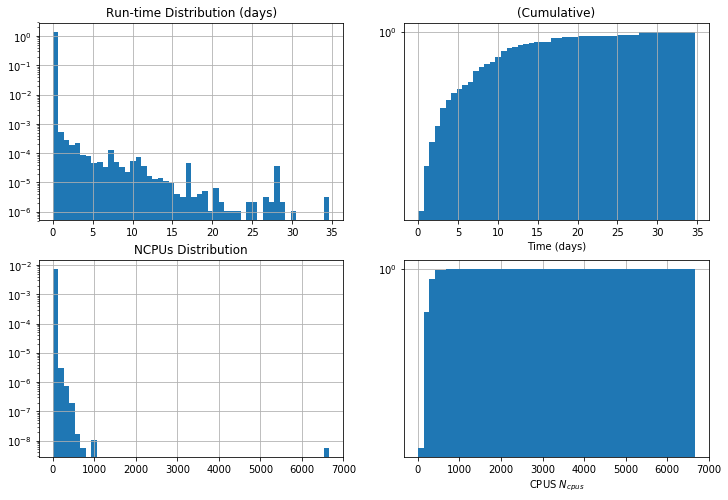

In [34]:
# compute some distributions:
print('*** ', sacct_mazama.jobs_summary.dtype.names)
run_times = sacct_mazama.get_run_times()

#
fg = plt.figure(figsize=(12,8))
ax1 = fg.add_subplot('221')
ax2 = fg.add_subplot('222')
#ax1a.set_yscale('log')
ax3 = fg.add_subplot('223')
ax4 = fg.add_subplot('224')
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
#
hh = ax1.hist(run_times, bins=50, cumulative=False, normed=True, log=True)
hh1c = ax2.hist(run_times, bins=50, cumulative=True, normed=True, log=True, histtype='bar')
#hh1c = ax2.plot(sorted(run_times), numpy.array(numpy.linspace(1./len(run_times), 1.,
#                                                             len(run_times))), lw=3.0, zorder=11)
#
hh2 = ax3.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True)
hh22 = ax4.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True,
                 cumulative=True, histtype='bar', lw=3, zorder=11)
#hh22 = ax4.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True,
#                 cumulative=True, histtype='step', lw=3, zorder=11)
#ax1.plot(run_times, ls='', marker='.')
#print('*** ', run_times[0:20]*24, len(run_times), run_times.shape)
#
ax1.set_title('Run-time Distribution (days)')
ax3.set_title('NCPUs Distribution')
ax2.set_xlabel('Time (days)')
ax4.set_xlabel('CPUS $N_{cpus}$')
#
ax2.set_title("(Cumulative)")
#ax4.set_title("(Cumulative)")

#ax2.set_xlim(-1,800)

In [17]:
print('** ', len(run_times), len(sacct_mazama.jobs_summary['NCPUS']))

**  1380849 1381096


In [18]:
#ix_rt = numpy.argsort(run_times)
run_times_sorted = run_times.copy()
run_times_sorted.sort()
#
k_2 = numpy.searchsorted(run_times_sorted, 2.0)
k_7 = numpy.searchsorted(run_times_sorted, 7.0)
k_14 = numpy.searchsorted(run_times_sorted, 14.0)

#
# k_2 = numpy.searchsorted(run_times[ix_rt], 2.0)
# #k_7 = numpy.searchsorted(run_times[ix_rt], 7.0)
# k_7 = k_2 + numpy.searchsorted( (run_times[ix_rt])[k_2:], 7.0)
# k_14 = k_7 + numpy.searchsorted( (run_times[ix_rt])[k_7:], 14.0)
#
N=float(len(run_times))
print('*** quantiles for t=2,7,14 days: {}, {}, {}'.format(float(k_2)/N, k_7/N, k_14/N))
#
# percent of jobs that use N<24 cores (aka, can run on a single node). Note that these are especially
#. eligible for GCP.
N_24 = numpy.sum(sacct_mazama.jobs_summary['NCPUS']<25)
print('*** N_24/N={}'.format(N_24/N))


*** quantiles for t=2,7,14 days: 0.9990614469793584, 0.9996379039272216, 0.999897164715331
*** N_24/N=0.8401273419468747


/Users/myoder96/Codes/HPC_analytics/hpc_lib.py:528: RuntimeWarning: invalid value encountered in greater_equal
  x_prime = delta_ts[numpy.logical_and(self.jobs_summary['NCPUS']==k, delta_ts>=0.)]


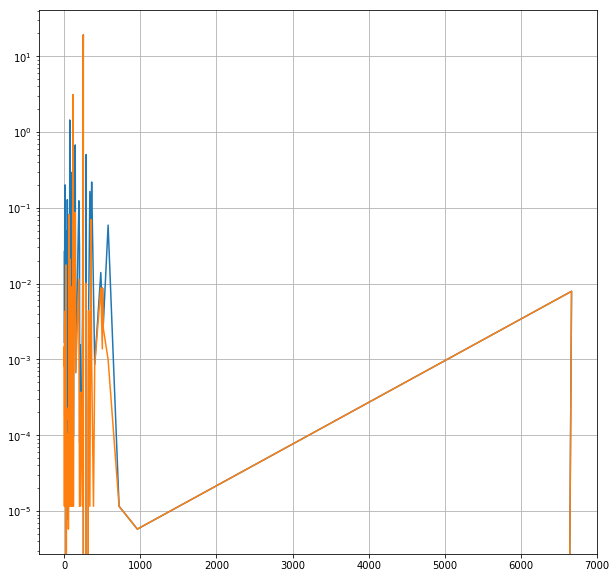

In [19]:
wait_stats = sacct_mazama.get_wait_stats()
#
fg = plt.figure(figsize=(10,10))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(wait_stats['ncpus'], wait_stats['mean'], ls='-', label='mean')
ax1.plot(wait_stats['ncpus'], wait_stats['median'], ls='-', label='median')
#
#ax1.set_ylim(-.1, .5)
ax1.set_yscale('log')

** DEBUG:  (1, 1381096) (1, 1381096)
***  ['2019-12-7', '2019-12-27', '2020-1-16', '2020-2-5', '2020-2-25', '2020-3-16', '2020-4-5', '2020-4-25', '2020-5-15']


Text(0.5, 0.98, 'Mazama Activity, $\\Delta t_{binsize}=7$ days')

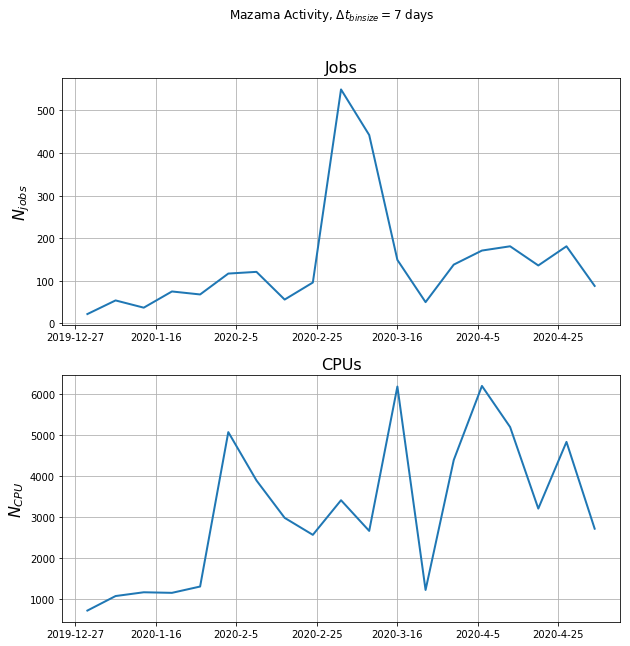

In [245]:
#t0 = mpd.date2num(dtm.datetime(2019,9,2, tzinfo=pytz.timezone('UTC')))
t0 = mpd.date2num(dtm.datetime(2019,12,30, tzinfo=pytz.timezone('UTC')))
#
bin_size=7
cpu_weekly = sacct_mazama.active_jobs_cpu(bin_size=bin_size, t_min=t0)
#
fg = plt.figure(figsize=(10,10))
plt.suptitle('Weekly Usage')
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='')

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
print('*** ', lbls)
#
ax2.set_xticklabels(lbls)
#
plt.suptitle('Mazama Activity, $\Delta t_{{binsize}}={}$ days'.format(bin_size))


In [20]:
#t0 = mpd.date2num(dtm.datetime(2019,9,2, tzinfo=pytz.timezone('UTC')))
t0 = mpd.date2num(dtm.datetime(2019,12,30, tzinfo=pytz.timezone('UTC')))
#
# and get a list of users to construct an index:
# $ finger dunham
# Login: edunham         Name: Eric Dunham
# Directory: /home/edunham             Shell: /bin/bash
# Never logged in.
# No mail.
# No Plan.
# [rcwhite@cees-mgmt0 ~]$ id edunham
# uid=60367(edunham) gid=100(users) groups=100(users),203(tgp),70137(fs-erd)
# [rcwhite@cees-mgmt0 ~]$ getent group | grep tgp
# tgp:*:203:ooreilly,kashefi,malmq,axelwang,lwat054,glotto,chao2,bponemon,danmohad,sinux1,
# gnava,eliasrh,dennis,zhuwq,yyang85,sbydlon,houyun,cstierns,mrivet,jlmaurer,myoder96,sozawa,schu3,
# lbruhat,kallison,labraha2,kcoppess,edunham
#
users = 'ooreilly,kashefi,malmq,axelwang,lwat054,glotto,chao2,bponemon,danmohad,sinux1,\
gnava,eliasrh,dennis,zhuwq,yyang85,sbydlon,houyun,cstierns,mrivet,jlmaurer,myoder96,sozawa,\
schu3,lbruhat,kallison,labraha2,kcoppess,edunham'.split(',')
users = [s for s in users if not s in ('myoder96', 'dennis')]
#print('** users: ', users)
#
ix = numpy.array([s in users for s in sacct_mazama.jobs_summary['User'] ])
#print('** ', (sacct_mazama.jobs_summary[ix])[0:20] )
#
cpu_weekly = sacct_mazama.active_jobs_cpu(bin_size=7., t_min=t0, ix=ix)
#
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='')
#
plt.suptitle('Dunham Group')
ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
print('*** ', lbls)
#
ax2.set_xticklabels(lbls)

** DEBUG:  (1386,) (1386,)


IndexError: tuple index out of range

In [ ]:
if True:
    with open(data_file_name, 'r') as fin:
        header_rw = fin.readline()
        print('*** ', header_rw)

    headers = header_rw.split('|')
    k_group = headers.index('Group')
    k_gid = headers.index('GID')
    #
    
    with open(data_file_name, 'r') as fin:
        for k,rw in enumerate(fin):
            #if 'dunham' in rw: print('** ', rw)
            #if 'dunham' in rw:
            #    rws = rw.split('|')
            #    print('** ', rws[k_group], rws[k_gid])
            if 'Partition_Limit' in rw:
                print('** ', rw)
                k+=1
                if k>10: break



In [ ]:
print('** ',sacct_mazama.jobs_summary.dtype.names)
print('** ', mpd.num2date(sacct_mazama.jobs_summary['Submit'][-1]))

In [ ]:
dta = sacct_mazama.jobs_summary.copy()
dta.sort(order='Submit')

TypeError: '>' not supported between instances of 'numpy.ndarray' and 'str'